## DOSYALARI YÜKLEME VE VERİNİN OLUŞTURULMASI


gerekli kütüphaneleri içe aktarır

In [28]:
!pip install -q catboost lightgbm
import pandas as pd
import pandas as pd
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from pathlib import Path

verileri içe aktarır

In [29]:

train_path ="/kaggle/input/ing-hubs-turkiye-datathon/referance_data.csv"
test_path ="/kaggle/input/ing-hubs-turkiye-datathon/referance_data_test.csv"
customers_path ="/kaggle/input/ing-hubs-turkiye-datathon/customers.csv"
history_path ="/kaggle/input/ing-hubs-turkiye-datathon/customer_history.csv"
sample_submission_path ="/kaggle/input/ing-hubs-turkiye-datathon/sample_submission.csv"

train_df = pd.read_csv(train_path, parse_dates=["ref_date"])
test_df = pd.read_csv(test_path, parse_dates=["ref_date"])
customers_df = pd.read_csv(customers_path)
history_df = pd.read_csv(history_path)

In [30]:
target = train_df["churn"].values.astype(int)
positive_ratio = target.mean()
print(f"Training samples: {len(train_df)} | Positive ratio: {positive_ratio:.4f}")

Training samples: 133287 | Positive ratio: 0.1416


Churn Sınıf dengesizliğinin  ve Train ile Test verilerindeki Zaman uyumsuzluğunun tespiti ve görselleştirilmesi.

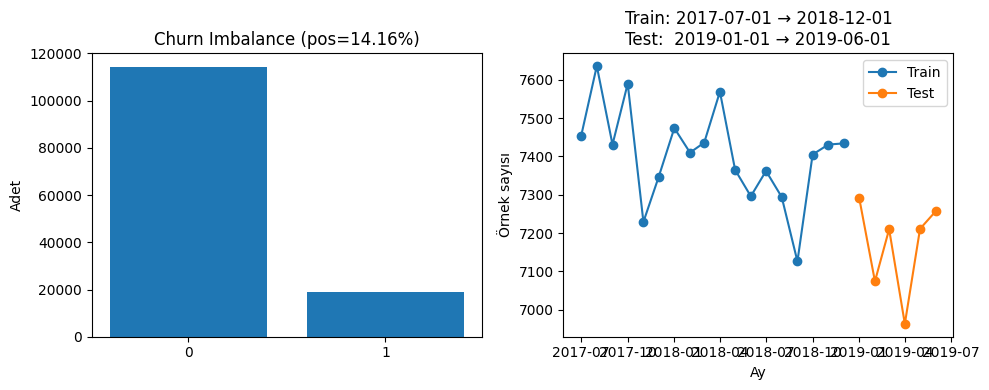

In [31]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))


vc = train_df["churn"].astype(int).value_counts().reindex([0,1], fill_value=0)
ax[0].bar(["0","1"], vc.values)
ax[0].set_title(f"Churn Imbalance (pos={vc.get(1,0)/vc.sum():.2%})")
ax[0].set_ylabel("Adet")


tr = train_df["ref_date"].dt.to_period("M").value_counts().sort_index()
te = test_df["ref_date"].dt.to_period("M").value_counts().sort_index()
ax[1].plot(tr.index.to_timestamp(), tr.values, marker="o", label="Train")
ax[1].plot(te.index.to_timestamp(), te.values, marker="o", label="Test")
ax[1].set_title(
    f"Train: {train_df.ref_date.min().date()} → {train_df.ref_date.max().date()}\n"
    f"Test:  {test_df.ref_date.min().date()} → {test_df.ref_date.max().date()}"
)
ax[1].set_xlabel("Ay"); ax[1].set_ylabel("Örnek sayısı"); ax[1].legend()
plt.tight_layout(); plt.show()


burada churn değişkeinin dengesiz dağılım yaptığını ve test ile train verisindeki zamanların tamamen farklı olduğunu görüyoruz.

## Özel Yarışma Metriği Hesaplaması

yarışma metriklerini hesaplayan yardımcı fonksiyonları tanımlar ve çıktıları ortak bir skorda birleştirmek için yardımcı metodlar sağlar.

In [32]:
import numpy as np
from typing import Dict, List, Optional, Tuple


TOP_DECILE = 0.10

def normalized_gini(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Gini = 2 * AUC - 1."""
    auc = roc_auc_score(y_true, y_pred)
    return 2.0 * auc - 1.0


def lift_at_k(y_true: np.ndarray, y_pred: np.ndarray, top_percent: float = TOP_DECILE) -> float:
    """Compute Lift at top_percent of the population."""
    order = np.argsort(-y_pred)
    cutoff = max(1, int(np.ceil(len(y_true) * top_percent)))
    top_true = y_true[order][:cutoff]
    baseline_rate = y_true.mean()
    top_rate = top_true.mean()
    if baseline_rate == 0:
        return np.nan
    return top_rate / baseline_rate


def recall_at_k(y_true: np.ndarray, y_pred: np.ndarray, top_percent: float = TOP_DECILE) -> float:
    """Recall captured within the top_percent highest predictions."""
    order = np.argsort(-y_pred)
    cutoff = max(1, int(np.ceil(len(y_true) * top_percent)))
    top_true = y_true[order][:cutoff]
    positives = y_true.sum()
    if positives == 0:
        return np.nan
    return top_true.sum() / positives


def competition_score(
    gini: float,
    lift10: float,
    recall10: float,
    baseline_gini: Optional[float],
    baseline_lift10: Optional[float],
    baseline_recall10: Optional[float],
) -> Optional[float]:
    """Compute competition score if baselines are supplied."""
    if None in (baseline_gini, baseline_lift10, baseline_recall10):
        return None
    gini_ratio = gini / baseline_gini if baseline_gini else np.nan
    lift_ratio = lift10 / baseline_lift10 if baseline_lift10 else np.nan
    recall_ratio = recall10 / baseline_recall10 if baseline_recall10 else np.nan
    return (
        0.40 * gini_ratio +
        0.30 * lift_ratio +
        0.30 * recall_ratio
    )


def custom_weighted_score(gini: float, lift10: float, recall10: float) -> float:
    """Weighted blend of metrics mirroring competition weights without baselines."""
    return (
        0.40 * gini +
        0.30 * lift10 +
        0.30 * recall10
    )

## Sabit değerlerin atanması

In [33]:
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
WINDOW_SIZES = [3, 6, 12]
TOP_DECILE = 0.10
MONTH_LAGS = [1, 2, 3, 4, 5, 6]
RECENT_WINDOW = 3
RECENT_LAG = 3
TARGET_ENCODING_FOLDS = 5
TARGET_ENCODING_SMOOTHING = 5.0
RECENT_ACTIVITY_BASE_COLS = [
    "total_txn_amt",
    "total_txn_cnt",
    "mobile_eft_all_amt",
    "mobile_eft_all_cnt",
    "cc_transaction_all_amt",
    "cc_transaction_all_cnt",
    "amt_per_active_product",
    "cnt_per_active_product",
]


## Featurelerin oluşturulması

müşteri işlem geçmişinden hareketli pencereler, gecikmeler ve oranlar gibi kapsamlı zaman serisi özellikleri türetir.

In [34]:
def compute_history_features(history: pd.DataFrame, windows: List[int]) -> pd.DataFrame:
    hist = history.copy()
    hist["date"] = pd.to_datetime(hist["date"])
    hist = hist.sort_values(["cust_id", "date"]).reset_index(drop=True)

    numeric_cols = [
        "mobile_eft_all_cnt",
        "mobile_eft_all_amt",
        "cc_transaction_all_amt",
        "cc_transaction_all_cnt",
        "active_product_category_nbr",
    ]

    for col in numeric_cols:
        hist[col] = hist[col].fillna(0.0)

    hist["total_txn_cnt"] = hist["mobile_eft_all_cnt"] + hist["cc_transaction_all_cnt"]
    hist["total_txn_amt"] = hist["mobile_eft_all_amt"] + hist["cc_transaction_all_amt"]
    hist["mobile_avg_ticket"] = np.where(
        hist["mobile_eft_all_cnt"] > 0,
        hist["mobile_eft_all_amt"] / hist["mobile_eft_all_cnt"],
        0.0,
    )
    hist["cc_avg_ticket"] = np.where(
        hist["cc_transaction_all_cnt"] > 0,
        hist["cc_transaction_all_amt"] / hist["cc_transaction_all_cnt"],
        0.0,
    )
    hist["overall_avg_ticket"] = np.where(
        hist["total_txn_cnt"] > 0,
        hist["total_txn_amt"] / hist["total_txn_cnt"],
        0.0,
    )
    hist["amt_per_active_product"] = np.where(
        hist["active_product_category_nbr"] > 0,
        hist["total_txn_amt"] / hist["active_product_category_nbr"],
        0.0,
    )
    hist["cnt_per_active_product"] = np.where(
        hist["active_product_category_nbr"] > 0,
        hist["total_txn_cnt"] / hist["active_product_category_nbr"],
        0.0,
    )
    hist["mobile_to_cc_amt_ratio"] = np.where(
        hist["cc_transaction_all_amt"] > 0,
        hist["mobile_eft_all_amt"] / hist["cc_transaction_all_amt"],
        0.0,
    )
    hist["mobile_to_cc_cnt_ratio"] = np.where(
        hist["cc_transaction_all_cnt"] > 0,
        hist["mobile_eft_all_cnt"] / hist["cc_transaction_all_cnt"],
        0.0,
    )

    derived_numeric_cols = [
        "total_txn_cnt",
        "total_txn_amt",
        "mobile_avg_ticket",
        "cc_avg_ticket",
        "overall_avg_ticket",
        "amt_per_active_product",
        "cnt_per_active_product",
        "mobile_to_cc_amt_ratio",
        "mobile_to_cc_cnt_ratio",
    ]
    for col in derived_numeric_cols:
        hist[col] = hist[col].fillna(0.0)
    numeric_cols.extend(derived_numeric_cols)

    hist["months_since_prev"] = (
        hist.groupby("cust_id")["date"].diff().dt.days.div(30.0).fillna(0.0)
    )
    hist["months_since_first"] = (
        hist["date"] - hist.groupby("cust_id")["date"].transform("min")
    ).dt.days.div(30.0)
    hist["history_obs_cnt"] = hist.groupby("cust_id").cumcount() + 1

    for col in numeric_cols:
        group = hist.groupby("cust_id")[col]
        for lag in MONTH_LAGS:
            lag_values = group.shift(lag).fillna(0.0)
            hist[f"{col}_lag{lag}"] = lag_values
            hist[f"{col}_delta{lag}"] = hist[col] - lag_values
            hist[f"{col}_ratio{lag}"] = hist[col] / (lag_values.abs() + 1e-3)

        cumsum = group.cumsum()
        cumcount = hist.groupby("cust_id").cumcount() + 1
        hist[f"{col}_cumsum"] = cumsum
        hist[f"{col}_cummean"] = cumsum / cumcount

        for window in windows:
            rolling = group.rolling(window=window, min_periods=1)
            hist[f"{col}_sum_win{window}"] = rolling.sum().reset_index(level=0, drop=True)
            hist[f"{col}_mean_win{window}"] = rolling.mean().reset_index(level=0, drop=True)
            hist[f"{col}_std_win{window}"] = rolling.std().reset_index(level=0, drop=True)

        hist[f"{col}_trend_win{windows[0]}"] = hist[col] - hist[f"{col}_mean_win{windows[0]}"]

        if 3 in windows and 12 in windows:
            hist[f"{col}_ratio_sum3_12"] = hist[f"{col}_sum_win3"] / (hist[f"{col}_sum_win12"] + 1e-3)
        if 6 in windows and 12 in windows:
            hist[f"{col}_ratio_sum6_12"] = hist[f"{col}_sum_win6"] / (hist[f"{col}_sum_win12"] + 1e-3)

        # recent-activity specialized features
        if col in RECENT_ACTIVITY_BASE_COLS:
            hist[f"{col}_abs_delta1"] = hist[f"{col}_delta1"].abs()
            zero_indicator = (hist[col].abs() <= 1e-6).astype(float)
            zero_roll = (
                zero_indicator.groupby(hist["cust_id"])
                .rolling(window=RECENT_WINDOW, min_periods=1)
                .sum()
                .reset_index(level=0, drop=True)
            )
            hist[f"{col}_zero_cnt_win{RECENT_WINDOW}"] = zero_roll
            hist[f"{col}_zero_flag_recent{RECENT_WINDOW}"] = (zero_roll >= RECENT_WINDOW).astype(int)

            abs_delta = hist[f"{col}_delta1"].abs()
            abs_delta_roll = (
                abs_delta.groupby(hist["cust_id"])
                .rolling(window=RECENT_WINDOW, min_periods=1)
                .sum()
                .reset_index(level=0, drop=True)
            )
            hist[f"{col}_abs_delta_sum_win{RECENT_WINDOW}"] = abs_delta_roll

            last_nonzero_date = hist["date"].where(hist[col].abs() > 1e-6)
            last_nonzero_ffill = last_nonzero_date.groupby(hist["cust_id"]).ffill()
            months_since_nonzero = (hist["date"] - last_nonzero_ffill).dt.days.div(30.0)
            hist[f"{col}_months_since_nonzero"] = months_since_nonzero.fillna(hist["months_since_first"])

    deriving_cols = {
        "cust_id",
        "date",
        "months_since_prev",
        "months_since_first",
        "history_obs_cnt",
    }
    deriving_cols.update(numeric_cols)
    feature_cols = {col for col in hist.columns if col not in {"date"} and col not in numeric_cols}
    deriving_cols.update(feature_cols)

    selected_cols = [col for col in hist.columns if col in deriving_cols]
    for col in selected_cols:
        if col not in {"cust_id", "date"} and hist[col].dtype.kind in {"f", "i"}:
            hist[col] = hist[col].astype(np.float32)
    return hist[selected_cols]


## Merge İşlemi

referans ve müşteri tablolarını birleştirir, tarih ve yakın dönem aktivite türevlerini üretir ve model girişi için öznitelik listelerini döndürür.

In [35]:
def build_dataset(reference_df: pd.DataFrame, history_features: pd.DataFrame, customers: pd.DataFrame) -> Tuple[pd.DataFrame, List[str], List[str]]:
    df = reference_df.copy()
    df["ref_date"] = pd.to_datetime(df["ref_date"])

    merged = df.merge(
        history_features,
        how="left",
        left_on=["cust_id", "ref_date"],
        right_on=["cust_id", "date"],
    )
    merged = merged.drop(columns=["date"], errors="ignore")

    merged = merged.merge(customers, how="left", on="cust_id", suffixes=("", "_customer"))

    merged["ref_year"] = merged["ref_date"].dt.year
    merged["ref_month"] = merged["ref_date"].dt.month
    merged["ref_quarter"] = merged["ref_date"].dt.quarter
    merged["ref_month_idx"] = (merged["ref_year"] * 12 + merged["ref_month"])
    merged["ref_month_sin"] = np.sin(2.0 * np.pi * merged["ref_month"] / 12.0)
    merged["ref_month_cos"] = np.cos(2.0 * np.pi * merged["ref_month"] / 12.0)
    merged["is_month_start"] = merged["ref_date"].dt.is_month_start.astype(int)
    merged["is_month_end"] = merged["ref_date"].dt.is_month_end.astype(int)
    merged["is_quarter_end"] = merged["ref_date"].dt.is_quarter_end.astype(int)

    merged["days_since_first_ref"] = (merged["ref_date"] - merged.groupby("cust_id")["ref_date"].transform("min")).dt.days

    categorical_cols = [
        "gender",
        "province",
        "religion",
        "work_type",
        "work_sector",
    ]
    for col in categorical_cols:
        if col in merged.columns:
            merged[col] = merged[col].fillna("Unknown").astype(str)

    for col in ["age", "tenure"]:
        if col in merged.columns:
            merged[col] = merged[col].fillna(merged[col].median())

    if "tenure" in merged.columns:
        merged["tenure_years"] = merged["tenure"] / 12.0
        merged["tenure_log"] = np.log1p(np.clip(merged["tenure"], a_min=0, a_max=None))
    else:
        merged["tenure_years"] = 0.0
        merged["tenure_log"] = 0.0

    if "age" in merged.columns:
        merged["age_log"] = np.log1p(np.clip(merged["age"], a_min=0, a_max=None))
    else:
        merged["age_log"] = 0.0

    merged["age_tenure_ratio"] = np.where(
        merged["tenure_years"] > 0,
        merged["age"] / merged["tenure_years"],
        0.0,
    )

    # recent-activity özetleri
    recent_activity_components = []
    recent_activity_share12_components = []
    for base_col in RECENT_ACTIVITY_BASE_COLS:
        available_series = []
        if base_col in merged.columns:
            available_series.append(merged[base_col])
        for lag in MONTH_LAGS:
            lag_col_name = f"{base_col}_lag{lag}"
            if lag_col_name in merged.columns:
                merged[f"{base_col}_month_minus{lag}"] = merged[lag_col_name]
                available_series.append(merged[lag_col_name])
        if available_series:
            for horizon in (1, 2, 3, 6):
                if len(available_series) >= horizon:
                    window_data = pd.concat(available_series[:horizon], axis=1)
                    merged[f"{base_col}_last{horizon}_sum"] = window_data.sum(axis=1)
                    merged[f"{base_col}_last{horizon}_mean"] = window_data.mean(axis=1)
            if len(available_series) >= 3:
                prev2_mean = pd.concat(available_series[1:3], axis=1).mean(axis=1)
                merged[f"{base_col}_last1_vs_prev2_mean"] = available_series[0] / (prev2_mean.abs() + 1e-3)
            if len(available_series) >= 6:
                window6 = pd.concat(available_series[:6], axis=1)
                merged[f"{base_col}_last6_max"] = window6.max(axis=1)
                merged[f"{base_col}_last6_min"] = window6.min(axis=1)
                merged[f"{base_col}_last6_range"] = window6.max(axis=1) - window6.min(axis=1)
                prev5_mean = pd.concat(available_series[1:6], axis=1).mean(axis=1)
                merged[f"{base_col}_last1_vs_prev5_mean"] = available_series[0] / (prev5_mean.abs() + 1e-3)

        sum3_col = f"{base_col}_sum_win{RECENT_WINDOW}"
        sum6_col = f"{base_col}_sum_win6"
        sum12_col = f"{base_col}_sum_win12"
        mean3_col = f"{base_col}_mean_win{RECENT_WINDOW}"
        mean6_col = f"{base_col}_mean_win6"
        cummean_col = f"{base_col}_cummean"

        if sum3_col not in merged.columns:
            continue

        merged[f"{base_col}_recent3_sum"] = merged[sum3_col]
        recent_activity_components.append(merged[f"{base_col}_recent3_sum"])

        if sum6_col in merged.columns:
            merged[f"{base_col}_recent3_share6"] = merged[sum3_col] / (merged[sum6_col] + 1e-3)
        if sum12_col in merged.columns:
            share12 = merged[sum3_col] / (merged[sum12_col] + 1e-3)
            merged[f"{base_col}_recent3_share12"] = share12
            recent_activity_share12_components.append(share12)
        if mean3_col in merged.columns:
            merged[f"{base_col}_recent3_mean"] = merged[mean3_col]
        if mean3_col in merged.columns and mean6_col in merged.columns:
            merged[f"{base_col}_recent3_trend"] = merged[mean3_col] - merged[mean6_col]
        if cummean_col in merged.columns:
            merged[f"{base_col}_recent3_vs_cum"] = merged[sum3_col] / (3.0 * merged[cummean_col] + 1e-3)

    if recent_activity_components:
        recent_matrix = np.vstack([series.values for series in recent_activity_components])
        merged["recent3_activity_index"] = recent_matrix.sum(axis=0)
        if recent_activity_share12_components:
            share_matrix = np.vstack([series.values for series in recent_activity_share12_components])
            merged["recent3_activity_share12_mean"] = share_matrix.mean(axis=0)
        if "history_obs_cnt" in merged.columns:
            merged["recent3_activity_density"] = merged["recent3_activity_index"] / (merged["history_obs_cnt"] + 1e-3)
        cust_recent_median = merged.groupby("cust_id")["recent3_activity_index"].transform("median")
        merged["recent3_activity_vs_median"] = merged["recent3_activity_index"] - cust_recent_median
        merged["recent3_high_activity_flag"] = (merged["recent3_activity_index"] > cust_recent_median).astype(int)
        cust_recent_mean = merged.groupby("cust_id")["recent3_activity_index"].transform("mean")
        cust_recent_std = merged.groupby("cust_id")["recent3_activity_index"].transform("std").fillna(0.0)
        merged["recent3_activity_zscore"] = (merged["recent3_activity_index"] - cust_recent_mean) / (cust_recent_std + 1e-3)
        merged["recent3_activity_log"] = np.log1p(np.clip(merged["recent3_activity_index"], a_min=0.0, a_max=None))
        merged["recent3_activity_per_age"] = merged["recent3_activity_index"] / (merged.get("age", 0.0) + 1.0)
        merged["recent3_activity_percentile_global"] = merged["recent3_activity_index"].rank(pct=True)
        merged["recent3_activity_percentile_month"] = merged.groupby("ref_month")["recent3_activity_index"].rank(pct=True)
        if "province" in merged.columns:
            merged["recent3_activity_percentile_province"] = merged.groupby("province")["recent3_activity_index"].rank(pct=True)

    zero_flag_cols = [
        f"{base_col}_zero_flag_recent{RECENT_WINDOW}"
        for base_col in RECENT_ACTIVITY_BASE_COLS
        if f"{base_col}_zero_flag_recent{RECENT_WINDOW}" in merged.columns
    ]
    if zero_flag_cols:
        zero_flag_matrix = np.vstack([merged[col].values for col in zero_flag_cols])
        merged["recent3_zero_metric_count"] = zero_flag_matrix.sum(axis=0)
        merged["recent3_all_zero_metric_flag"] = (merged["recent3_zero_metric_count"] == zero_flag_matrix.shape[0]).astype(int)
        merged["recent3_any_zero_metric_flag"] = (zero_flag_matrix.sum(axis=0) > 0).astype(int)

    months_since_cols = [
        f"{base_col}_months_since_nonzero"
        for base_col in RECENT_ACTIVITY_BASE_COLS
        if f"{base_col}_months_since_nonzero" in merged.columns
    ]
    if months_since_cols:
        months_matrix = np.vstack([merged[col].values for col in months_since_cols])
        merged["recent_months_since_activity_min"] = months_matrix.min(axis=0)
        merged["recent_months_since_activity_max"] = months_matrix.max(axis=0)
        merged["recent_months_since_activity_mean"] = months_matrix.mean(axis=0)

    if {"total_txn_amt_recent3_sum", f"total_txn_amt_lag{RECENT_LAG}"} <= set(merged.columns):
        merged["total_txn_amt_recent3_vs_lag"] = merged["total_txn_amt_recent3_sum"] / (merged[f"total_txn_amt_lag{RECENT_LAG}"].abs() + 1e-3)
    if {"total_txn_cnt_recent3_sum", f"total_txn_cnt_lag{RECENT_LAG}"} <= set(merged.columns):
        merged["total_txn_cnt_recent3_vs_lag"] = merged["total_txn_cnt_recent3_sum"] / (merged[f"total_txn_cnt_lag{RECENT_LAG}"].abs() + 1e-3)

    # Na doldurma numeric için
    numeric_cols = merged.select_dtypes(include=["number"]).columns.tolist()
    for col in numeric_cols:
        if col not in {"cust_id", "churn"} and merged[col].isna().any():
            merged[col] = merged[col].fillna(0.0)

    feature_cols = [col for col in merged.columns if col not in {"cust_id", "ref_date", "churn"}]

    return merged, categorical_cols, feature_cols


## Target Encoding

kategorik değişkenleri grup bazlı çapraz doğrulama ile smootlaştırılmış target encoding özelliklerine dönüştürür.

In [36]:
def generate_group_target_encodings(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    categorical_cols: List[str],
    target_col: str,
    groups: np.ndarray,
    folds: int = TARGET_ENCODING_FOLDS,
    smoothing: float = TARGET_ENCODING_SMOOTHING,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if not categorical_cols:
        empty_train = pd.DataFrame(index=train_df.index)
        empty_test = pd.DataFrame(index=test_df.index)
        return empty_train, empty_test

    y = train_df[target_col].values
    global_mean = float(np.mean(y))
    enc_train = pd.DataFrame(index=train_df.index)
    enc_test = pd.DataFrame(index=test_df.index)

    for col in categorical_cols:
        oof = np.full(len(train_df), global_mean, dtype=float)
        splitter = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
        for train_idx, val_idx in splitter.split(train_df, y, groups):
            tr_part = train_df.iloc[train_idx]
            stats = tr_part.groupby(col)[target_col].agg(["mean", "count"])
            smooth = (stats["mean"] * stats["count"] + global_mean * smoothing) / (stats["count"] + smoothing)
            mapping = smooth.to_dict()
            val_values = train_df[col].iloc[val_idx].map(mapping).fillna(global_mean)
            oof[val_idx] = val_values.values

        enc_train[f"{col}_te"] = oof

        full_stats = train_df.groupby(col)[target_col].agg(["mean", "count"])
        smooth_full = (full_stats["mean"] * full_stats["count"] + global_mean * smoothing) / (full_stats["count"] + smoothing)
        mapping_full = smooth_full.to_dict()
        enc_test[f"{col}_te"] = test_df[col].map(mapping_full).fillna(global_mean)

    return enc_train, enc_test


## Parametre araması

CatBoost ve LightGBM modelleri için sınırlı bir hiperparametre ızgarasında stratified arama yaparak en iyi ayarları bulur.

In [37]:
def stratified_parameter_search(
    model_name: str,
    param_grid: List[Dict],
    X: pd.DataFrame,
    y: np.ndarray,
    scale_pos_weight: float,
    cat_features: Optional[List[str]] = None,
    folds: int = 3,
    groups: Optional[np.ndarray] = None,
) -> Dict:
    best_score = -np.inf
    best_params: Optional[Dict] = None

    for params in param_grid:
        fold_scores: List[float] = []
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
            split_iter = splitter.split(X, y, groups)
        else:
            splitter = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
            split_iter = splitter.split(X, y)

        for train_idx, val_idx in split_iter:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if model_name == "catboost":
                model = CatBoostClassifier(
                    loss_function="Logloss",
                    eval_metric="AUC",
                    random_seed=RANDOM_STATE,
                    verbose=False,
                    od_type="Iter",
                    od_wait=100,
                    scale_pos_weight=scale_pos_weight,
                    **params,
                )
                model.fit(
                    X_train,
                    y_train,
                    eval_set=(X_val, y_val),
                    cat_features=cat_features,
                    use_best_model=True,
                )
                preds = model.predict_proba(X_val)[:, 1]

            elif model_name == "lightgbm":
                model = lgb.LGBMClassifier(
                    objective="binary",
                    n_estimators=5000,
                    random_state=RANDOM_STATE,
                    n_jobs=-1,
                    scale_pos_weight=scale_pos_weight,
                    **params,
                )
                callbacks = [lgb.early_stopping(200)]
                model.fit(
                    X_train,
                    y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric="auc",
                    callbacks=callbacks,
                    categorical_feature=cat_features if cat_features else "auto",
                )
                best_iter = model.best_iteration_ or model.n_estimators
                preds = model.predict_proba(X_val, num_iteration=best_iter)[:, 1]
            else:
                raise ValueError(f"Unsupported model: {model_name}")

            fold_scores.append(roc_auc_score(y_val, preds))

        mean_score = float(np.mean(fold_scores))
        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    if best_params is None:
        raise RuntimeError(f"No best params identified for {model_name}")

    return {"params": best_params, "score": best_score}


## Catboost ve Lightgbm modellerinin cross validation yapılışı

CatBoost modelini çapraz doğrulama ile eğitir, out-of-fold tahminleri, test tahminlerini ve önem puanlarını toplar.

LightGBM modelini kategori bilgisiyle çapraz doğrular, tahminleri ve özellik önemlerini hesaplar.

In [38]:
def cross_validate_catboost(
    X: pd.DataFrame,
    y: np.ndarray,
    X_test: pd.DataFrame,
    params: Dict,
    cat_features: List[str],
    scale_pos_weight: float,
    folds: int = 5,
    groups: Optional[np.ndarray] = None,
) -> Dict:
    """Run stratified CV for CatBoost and collect predictions."""
    if groups is not None:
        splitter = StratifiedGroupKFold(
            n_splits=folds, shuffle=True, random_state=RANDOM_STATE
        )
        split_iter = splitter.split(X, y, groups)
    else:
        splitter = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
        split_iter = splitter.split(X, y)
    oof = np.zeros(len(y), dtype=float)
    test_predictions: List[np.ndarray] = []
    feature_importances: List[np.ndarray] = []
    fold_metrics: List[float] = []

    for fold, (train_idx, val_idx) in enumerate(split_iter, start=1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=RANDOM_STATE + fold,
            verbose=False,
            od_type="Iter",
            od_wait=150,
            scale_pos_weight=scale_pos_weight,
            **params,
        )
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            cat_features=cat_features,
            use_best_model=True,
        )

        preds_val = model.predict_proba(X_val)[:, 1]
        oof[val_idx] = preds_val
        fold_auc = roc_auc_score(y_val, preds_val)
        fold_metrics.append(fold_auc)
        preds_test = model.predict_proba(X_test)[:, 1]
        test_predictions.append(preds_test)
        feature_importances.append(model.get_feature_importance(type="FeatureImportance"))

        print(f"[CatBoost] Fold {fold} AUC: {fold_auc:.5f}")

    mean_auc = float(np.mean(fold_metrics))
    print(f"[CatBoost] Mean AUC across folds: {mean_auc:.5f}")

    feature_importance = np.mean(feature_importances, axis=0)
    importance_series = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

    return {
        "oof": oof,
        "test": np.mean(test_predictions, axis=0),
        "importance": importance_series,
        "metrics": {
            "fold_auc": fold_metrics,
            "mean_auc": mean_auc,
        },
    }

In [39]:
def cross_validate_lightgbm(
    X: pd.DataFrame,
    y: np.ndarray,
    X_test: pd.DataFrame,
    params: Dict,
    scale_pos_weight: float,
    categorical_cols: List[str],
    folds: int = 5,
    groups: Optional[np.ndarray] = None,
) -> Dict:
    """Run stratified CV for LightGBM."""
    if groups is not None:
        splitter = StratifiedGroupKFold(
            n_splits=folds, shuffle=True, random_state=RANDOM_STATE
        )
        split_iter = splitter.split(X, y, groups)
    else:
        splitter = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
        split_iter = splitter.split(X, y)
    oof = np.zeros(len(y), dtype=float)
    test_predictions: List[np.ndarray] = []
    feature_importances: List[np.ndarray] = []
    fold_metrics: List[float] = []

    for fold, (train_idx, val_idx) in enumerate(split_iter, start=1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y[train_idx], y[val_idx]

        model = lgb.LGBMClassifier(
            objective="binary",
            n_estimators=5000,
            random_state=RANDOM_STATE + fold,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight,
            **params,
        )

        callbacks = [lgb.early_stopping(200)]
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=callbacks,
            categorical_feature=categorical_cols if categorical_cols else "auto",
        )

        best_iter = model.best_iteration_ or model.n_estimators
        preds_val = model.predict_proba(X_val, num_iteration=best_iter)[:, 1]
        oof[val_idx] = preds_val
        fold_auc = roc_auc_score(y_val, preds_val)
        fold_metrics.append(fold_auc)
        preds_test = model.predict_proba(X_test, num_iteration=best_iter)[:, 1]
        test_predictions.append(preds_test)
        feature_importances.append(model.feature_importances_)

        print(f"[LightGBM] Fold {fold} AUC: {fold_auc:.5f}")

    mean_auc = float(np.mean(fold_metrics))
    print(f"[LightGBM] Mean AUC across folds: {mean_auc:.5f}")

    importance_series = pd.Series(
        np.mean(feature_importances, axis=0),
        index=X.columns,
    ).sort_values(ascending=False)

    return {
        "oof": oof,
        "test": np.mean(test_predictions, axis=0),
        "importance": importance_series,
        "metrics": {
            "fold_auc": fold_metrics,
            "mean_auc": mean_auc,
        },
    }

In [ ]:
history_features = compute_history_features(history_df, WINDOW_SIZES)
train_merged, cat_cols, feature_cols = build_dataset(train_df, history_features, customers_df)
test_merged, _, _ = build_dataset(test_df, history_features, customers_df)
print("Shapes:", train_merged.shape, test_merged.shape)


## Target Encoding

kategorik alanlar için grup bazlı yumuşatılmış hedef kodlama değerleri üretir

In [ ]:
groups = train_merged["cust_id"].values
target = train_merged["churn"].values.astype(int)
target_encoding_cols = [col for col in ["province", "work_type", "work_sector", "gender", "religion"] if col in train_merged.columns]

train_te, test_te = generate_group_target_encodings(
    train_merged,
    test_merged,
    target_encoding_cols,
    target_col="churn",
    groups=groups,
    folds=TARGET_ENCODING_FOLDS,
    smoothing=TARGET_ENCODING_SMOOTHING,
)
if not train_te.empty:
    train_merged = pd.concat([train_merged, train_te], axis=1)
    test_merged = pd.concat([test_merged, test_te], axis=1)
    feature_cols.extend(train_te.columns.tolist())

X = train_merged[feature_cols].copy()
X_test = test_merged[feature_cols].copy()

# categorical dönüşümleri
for col in cat_cols:
    if col in X.columns:
        X[col] = X[col].astype(str)
        X_test[col] = X_test[col].astype(str)
        all_values = pd.concat([X[col], X_test[col]], axis=0)
        X[col] = pd.Categorical(X[col], categories=all_values.unique())
        X_test[col] = pd.Categorical(X_test[col], categories=all_values.unique())

scale_pos_weight = float((len(target) - target.sum()) / (target.sum() + 1e-12))
print(f"Using scale_pos_weight: {scale_pos_weight:.4f}")


## Parametre grid arama

parametre aranacak aralığı belirler ve parametreleri arar

In [ ]:
catboost_param_grid = [
    {"depth": 6, "learning_rate": 0.05, "l2_leaf_reg": 3.0, "iterations": 2000},
    {"depth": 7, "learning_rate": 0.04, "l2_leaf_reg": 4.0, "iterations": 2500},
    {"depth": 8, "learning_rate": 0.03, "l2_leaf_reg": 5.0, "iterations": 3000},
]

lightgbm_param_grid = [
    {
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "min_child_samples": 40,
        "reg_lambda": 1.0,
    },
    {
        "num_leaves": 48,
        "learning_rate": 0.04,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.9,
        "bagging_freq": 1,
        "min_child_samples": 30,
        "reg_lambda": 2.0,
    },
    {
        "num_leaves": 64,
        "learning_rate": 0.03,
        "feature_fraction": 0.85,
        "bagging_fraction": 0.85,
        "bagging_freq": 1,
        "min_child_samples": 25,
        "reg_lambda": 1.5,
    },
]

print("Searching CatBoost parameters...")
catboost_search = stratified_parameter_search(
    "catboost",
    catboost_param_grid,
    X,
    target,
    scale_pos_weight=scale_pos_weight,
    cat_features=[c for c in cat_cols if c in X.columns],
    folds=3,
    groups=groups,
)
print(f"Best CatBoost params: {catboost_search['params']} with AUC {catboost_search['score']:.5f}")

print("Searching LightGBM parameters...")
lightgbm_search = stratified_parameter_search(
    "lightgbm",
    lightgbm_param_grid,
    X,
    target,
    scale_pos_weight=scale_pos_weight,
    cat_features=[c for c in cat_cols if c in X.columns],
    folds=3,
    groups=groups,
)
print(f"Best LightGBM params: {lightgbm_search['params']} with AUC {lightgbm_search['score']:.5f}")


    print("Running CatBoost cross-validation...")
    catboost_cv = cross_validate_catboost(
        X,
        target,
        X_test,
        params=catboost_search["params"],
        cat_features=cat_feature_names,
        scale_pos_weight=scale_pos_weight,
        folds=5,
        groups=groups,
    )

    print("Running LightGBM cross-validation...")
    lightgbm_cv = cross_validate_lightgbm(
        X,
        target,
        X_test,
        params=lightgbm_search["params"],
        scale_pos_weight=scale_pos_weight,
        categorical_cols=cat_cols,
        folds=5,
        groups=groups,
    )

## Ensemble ve submission hazırlama

Ensemble oluşturur ve çıktıları kaydeder

In [ ]:
    cat_metrics = evaluate_predictions("CatBoost OOF", target, catboost_cv["oof"])
    lgb_metrics = evaluate_predictions("LightGBM OOF", target, lightgbm_cv["oof"])

    ensemble_oof = 0.5 * catboost_cv["oof"] + 0.5 * lightgbm_cv["oof"]
    ensemble_metrics = evaluate_predictions("Ensemble OOF", target, ensemble_oof)
    print(
        "Custom weighted score for Ensemble OOF (0.40*gini + 0.30*lift10 + 0.30*recall10): "
        f"{ensemble_metrics['custom_score']:.5f}"
    )

    # Weighted ensemble using Gini improvements
    gini_cat = max(cat_metrics["gini"], 1e-6)
    gini_lgb = max(lgb_metrics["gini"], 1e-6)
    weight_cat = gini_cat / (gini_cat + gini_lgb)
    weight_lgb = gini_lgb / (gini_cat + gini_lgb)
    print(f"Ensemble weights -> CatBoost: {weight_cat:.3f} | LightGBM: {weight_lgb:.3f}")

    final_test_pred = weight_cat * catboost_cv["test"] + weight_lgb * lightgbm_cv["test"]
    final_test_pred = np.clip(final_test_pred, 0.0, 1.0)

    competition_baseline = competition_score(
        ensemble_metrics["gini"],
        ensemble_metrics["lift10"],
        ensemble_metrics["recall10"],
        baseline_gini=None,
        baseline_lift10=None,
        baseline_recall10=None,
    )
    if competition_baseline is not None:
        print(f"Estimated competition score: {competition_baseline:.5f}")
    else:
        print("Competition baselines not provided; skipped composite score.")

    # Diagnostics for top customers
    top_n = 10
    top_indices = np.argsort(-ensemble_oof)[:top_n]
    top_customers = train_df.iloc[top_indices][["cust_id", "ref_date", "churn"]]
    print(f"Top {top_n} customers by predicted churn probability (OOF preview):")
    print(top_customers.assign(pred=ensemble_oof[top_indices]))

    submission = pd.read_csv(sample_submission_path)
    submission = submission.drop(columns=[col for col in submission.columns if col != "cust_id"], errors="ignore")
    submission = submission.merge(
        pd.DataFrame({"cust_id": test_df["cust_id"], "churn": final_test_pred}),
        on="cust_id",
        how="right",
    )

    submission_path = data_dir / "submission.csv"
    submission.rename(columns={"churn": "churn"}, inplace=True)
    submission.to_csv(submission_path, index=False)
    print(f"Submission saved to {submission_path}")

    print("Top CatBoost features:")
    print(catboost_cv["importance"].head(15))

    print("Top LightGBM features:")
    print(lightgbm_cv["importance"].head(15))
